# Classification Hypernetwork Test

In [4]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !tar -xvf VOCtrainval_11-May-2012.tar

--2023-09-04 16:03:32--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  5.79MB/s    in 4m 18s  

2023-09-04 16:07:51 (7.38 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

VOCdevkit/
VOCdevkit/VOC2012/
VOCdevkit/VOC2012/Annotations/
VOCdevkit/VOC2012/Annotations/2007_000027.xml
VOCdevkit/VOC2012/Annotations/2007_000032.xml
VOCdevkit/VOC2012/Annotations/2007_000033.xml
VOCdevkit/VOC2012/Annotations/2007_000039.xml
VOCdevkit/VOC2012/Annotations/2007_000042.xml
VOCdevkit/VOC2012/Annotations/2007_000061.xml
VOCdevkit/VOC2012/Annotations/2007_000063.xml
VOCdevkit/VOC2012/Annotations/2007_000068.xml

In [10]:
!python train.py

100%|██████████████████████| 1999639040/1999639040 [04:24<00:00, 7570282.56it/s]
Extracting VOCdevkit/VOC2012/VOCtrainval_11-May-2012.tar to VOCdevkit/VOC2012/
Using downloaded and verified file: VOCdevkit/VOC2012/VOCtrainval_11-May-2012.tar
Extracting VOCdevkit/VOC2012/VOCtrainval_11-May-2012.tar to VOCdevkit/VOC2012/
Traceback (most recent call last):
  File "/home/jianingqi/HyperNetworks/train.py", line 129, in <module>
    for i, (inputs, targets) in enumerate(dataloaders['train']):
  File "/home/jianingqi/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/home/jianingqi/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/home/jianingqi/miniconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/home/jianingqi/miniconda3/lib/python3.10/site-pac

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn

import argparse

import torch.optim as optim

from primary_net import PrimaryNetwork

#Data Loader for VOC2012
import torchvision.datasets as datasets

from torchvision.datasets import VOCDetection
import torch

class CustomVOCDataset(VOCDetection):
    def __init__(self, root, year='2012', image_set='train', transform=None, target_transform=None):
        super(CustomVOCDataset, self).__init__(root, year=year, image_set=image_set, transform=transform, target_transform=target_transform)
        self.classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

    def __getitem__(self, index):
        img, target = super(CustomVOCDataset, self).__getitem__(index)
        
        lbl = torch.zeros(len(self.classes))
        for obj in target['annotation']['object']:
            if obj['name'] in self.classes:
                class_idx = self.classes.index(obj['name'])
                lbl[class_idx] = 1
        
        return img, lbl

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data_dir = 'VOCdevkit/VOC2012/'  # adjust if necessary

train_dataset = CustomVOCDataset(root=data_dir, year='2012', image_set='train', transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = CustomVOCDataset(root=data_dir, year='2012', image_set='val', transform=transform)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


In [2]:
#check the dimension of trainloader images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(torch.tensor(images).size())

torch.Size([32, 3, 256, 256])


/tmp/ipykernel_22222/2414598861.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(images).size())


In [3]:
from primary_net import PrimaryNetwork

net = PrimaryNetwork()
best_accuracy = 0.

net.cuda()

learning_rate = 0.002
weight_decay = 0.0005
milestones = [168000, 336000, 400000, 450000, 550000, 600000]
max_iter = 100000

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=0.5)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()  # This is used for multi-label classification


total_iter = 0
epochs = 0
print_freq = 50

In [4]:
def validate(net, valloader, criterion):
    net.eval()
    val_loss = 0.0
    correct_labels = 0
    total_samples = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valloader):
            inputs, labels = inputs.cuda(), labels.cuda()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted_labels = outputs > 0.5  # Threshold the outputs
            total_samples += labels.size(0)
            correct_labels += (predicted_labels == labels.byte()).sum().item()

    avg_val_loss = val_loss / len(valloader)
    accuracy = 100 * correct_labels / (total_samples * len(classes))  # Calculating accuracy over all classes
    
    return avg_val_loss, accuracy

In [5]:
while total_iter < max_iter:

    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        # print(inputs.size())
        outputs = net(inputs)
        # print(outputs.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        lr_scheduler.step()

        running_loss += loss.data
        if i % print_freq == (print_freq-1):
            print("[Epoch %d, Total Iterations %6d] Loss: %.4f" % (epochs + 1, total_iter + 1, running_loss/print_freq))
            running_loss = 0.0

        total_iter += 1

    epochs += 1
    # At the end of each epoch, or whenever you want to check performance on the validation set:
    val_loss, val_accuracy = validate(net, valloader, criterion)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')







[Epoch 1, Total Iterations     50] Loss: 0.3089
[Epoch 1, Total Iterations    100] Loss: 0.2470
[Epoch 1, Total Iterations    150] Loss: 0.2409
Validation Loss: 0.2400, Validation Accuracy: 92.41%
[Epoch 2, Total Iterations    229] Loss: 0.2456
[Epoch 2, Total Iterations    279] Loss: 0.2430
[Epoch 2, Total Iterations    329] Loss: 0.2415
Validation Loss: 0.2376, Validation Accuracy: 92.40%
[Epoch 3, Total Iterations    408] Loss: 0.2427
[Epoch 3, Total Iterations    458] Loss: 0.2421
[Epoch 3, Total Iterations    508] Loss: 0.2403
Validation Loss: 0.2376, Validation Accuracy: 92.40%
[Epoch 4, Total Iterations    587] Loss: 0.2425
[Epoch 4, Total Iterations    637] Loss: 0.2414
[Epoch 4, Total Iterations    687] Loss: 0.2404
Validation Loss: 0.2368, Validation Accuracy: 92.40%
[Epoch 5, Total Iterations    766] Loss: 0.2406
[Epoch 5, Total Iterations    816] Loss: 0.2426
[Epoch 5, Total Iterations    866] Loss: 0.2413
Validation Loss: 0.2366, Validation Accuracy: 92.40%
[Epoch 6, Total

KeyboardInterrupt: 

# Segmentation Hypernetwork Test

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn

import argparse

import torch.optim as optim

from primary_net import PrimaryNetwork

#Data Loader for VOC2012
import torchvision.datasets as datasets

from torchvision.datasets import VOCDetection
import torch

import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a consistent size
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),  # For masks, use nearest neighbor interpolation
    transforms.ToTensor(),
])



data_dir = 'VOCdevkit/VOC2012/'  # adjust if necessary

# Load PASCAL VOC train and validation datasets
train_dataset = VOCSegmentation(root=data_dir , year='2012', image_set='train', download=False, transform=transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root=data_dir, year='2012', image_set='val', transform=transform, target_transform=target_transform)

# Create DataLoader instances
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)


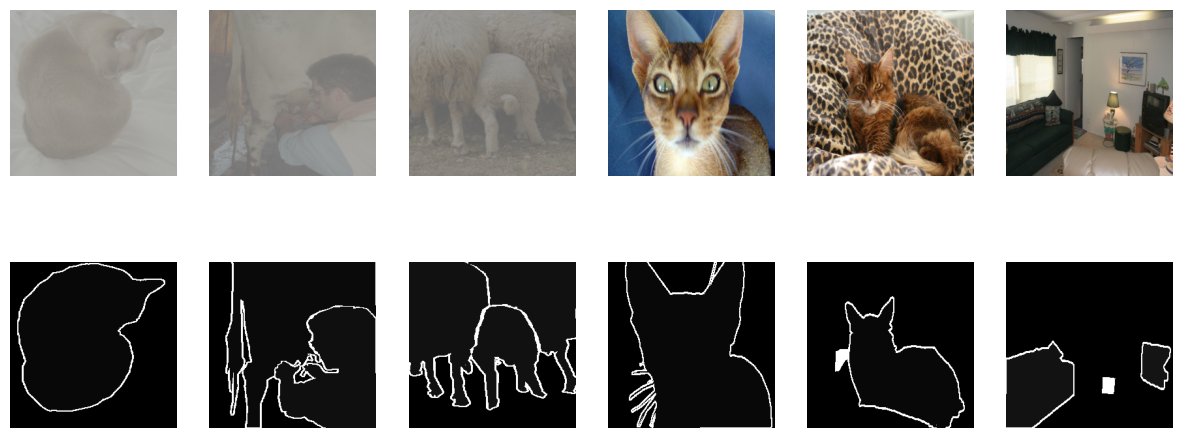

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize and convert tensor to numpy for visualization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Get a batch of data
data_iter = iter(train_loader)
images, masks = next(data_iter)

# Denormalize images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images = denormalize(images, mean, std)

# Number of images to display
num_images = 6

fig, axarr = plt.subplots(2, num_images, figsize=(15, 6))

# Display images and masks
for idx in range(num_images):
    axarr[0, idx].imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
    axarr[0, idx].axis('off')
    
    axarr[1, idx].imshow(masks[idx].squeeze().numpy(), cmap='gray')
    axarr[1, idx].axis('off')

plt.show()
